In [3]:
names_dict = {
0: 'Bar',
1: 'Bathroom',
2: 'Bedroom',
3: 'Breakfast',
4: 'City View',
5: 'Dining',
6: 'Hotel Front',
7: 'Hotel Exterior View',
8: 'Hotel Interior View',
9: 'Kitchen',
10: 'Living Room',
11: 'Lobby',
12: 'Natural View',
13: 'Pool',
14: 'Recreation',
15: 'Sports'}

label_to_names =  dict()
for k in names_dict.keys():
    v = names_dict[k]
    label_to_names[v] = k



In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [5]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize(310),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #transforms.CenterCrop(299),
        transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(10),
        transforms.ColorJitter(),
        transforms.ToTensor() ,
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        # transforms.Resize(310),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #transforms.CenterCrop(299),
        transforms.ToTensor() ,
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        # transforms.Resize(310),
        transforms.Resize(256),
         transforms.CenterCrop(224),
        #transforms.CenterCrop(299),
        transforms.ToTensor() ,
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
data_dir = '../data/'
image_datasets = {'train': datasets.ImageFolder(data_dir+'train',
                                          data_transforms['train']),
                  'test': ImageFolderWithPaths(data_dir+'test',
                                          data_transforms['test']) 
                  }

# 1 Batch size 4 - learning rate 0.001 - 1 epoch - learning rate decay every 7 0.45516 0.53 acc resnet18
# 2 Batch Size 64 learning rate 0.0008 - 20 epochs (14 ok) - learning rate decay every 10 0.8 acc 0.57594 resnet18
# 3 Batch Size 64 learning rate default - 35 epochs - 0.511 Adam acc 0.8047 resnet50
# 4 Batch Size 16 learning rate 0.001 - 8 epochs - 0.64 0.94 acc vgg19
# 5 Batch Size 16 learning rate 0.001 - 20 epochs - 0.62418 0.9854 acc vgg19_bn
# 6 Batch Size 16 learning rate 0.001 - 40 epochs - 0.66 0.9854 acc vgg19_bn
# 8 Batch Size 16 learning rate 1e-6 - 40 epochs - 0.63 0.8 acc densenet161 RMSProp
# 9 Batch Size 16 learning rate 1e-7 - 100 epochs - 0.49 0.7 acc densenet161 RMSProp
# 9 Batch Size 16 learning rate 1e-6 - 90 epochs - 0.63 0.8 acc densenet161 RMSProp
# 13 Batch Size 16 learning rate 1e-6 - 80 epchs - 0.64  0.95 acc 0.82 valacc resnet50 (from scratch ) Adam
# * 14 Batch Size 16 learning rate 1e-6 - 37 epchs (20?) - 0.65304 <3  0.95 acc 0.83 valacc resnet152 (from scratch ) Adam
# 15 Batch Size 16 learning rate 8e-7 - 37 epchs(20?) - 0.64 nah 0.95 acc 0.83 valacc resnet152 (from scratch ) Adam
# 16 resnet152_Adam-1e-06-60ep16bs_1562508327 0.6507479833577965
# Batch Size 16 learning rate 1e-6 - 80 epchs  - inception (from scratch ) Adagrad
# Batch Size 16 learning rate 1e-6 - 80 epchs  - inception (from scratch ) Adamax
# next Batch Size 16 learning rate 7e-7 - 80 epchs  - inception (from scratch ) Adam
# next Batch Size 32 learning rate 1e-6 - 80 epchs  - inception (from scratch ) Adam
# probar Batch Size 16 learning rate 4e-7 - 37 epchs -  resnet152 (from scratch ) Adam
# probar  Sin color gittler Batch Size 16 learning rate 1e-6 - 37 epchs (20?) - 0.65304 <3  0.95 acc 0.83 valacc resnet152 (from scratch ) Adam
# probar  Batch Size 32 learning rate 1e-6 - 37 epchs (20?) - 0.65304 <3  0.95 acc 0.83 valacc resnet152 (from scratch ) Adam
# Objetivo: superar el 83% Target minimo 87%
# final 1: Batch Size 16 learning rate 1e-6 - 20 epchs resnet152 TODO TRAINING SET
# * 14 Batch Size 16 learning rate 1e-6 - 30 epchs (20?) 0.71888 --corregido
# * 14 Batch Size 16 learning rate 1e-6 - 30 epchs (20?) 0.76 weighted --corregido

batch_size = 16
use_validation = True
dataloaders = dict()

if use_validation:
    validation_split = .2
    random_seed= 17

    dataset_size = len(image_datasets['train'])
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    dataset_sizes = {'train': len(train_indices), 'valid': len(val_indices)}
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
   
    dataloaders['train'] = DataLoader(image_datasets['train'], batch_size=batch_size,  sampler=train_sampler)
    dataloaders['valid'] = DataLoader(image_datasets['train'], batch_size=batch_size,  sampler=valid_sampler)
else:
    dataloaders['train'] = DataLoader(image_datasets['train'], batch_size=batch_size,  shuffle=True)

dataloaders['test'] = DataLoader(image_datasets['test'], batch_size=batch_size)

class_names = image_datasets['train'].classes
print(class_names)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

['Bar', 'Bathroom', 'Bedroom', 'Breakfast', 'City View', 'Dining', 'Hotel Front', 'Hotel Front2 -Exterior View', 'Hotel Interior View', 'Kitchen', 'Living Room', 'Lobby', 'Natural View', 'Pool', 'Recreation', 'Sports']


In [6]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
y_train = []
with torch.no_grad():
    for inputs, labels  in dataloaders['valid']:
            y_train += labels.data.cpu().tolist()

y_train_count = [0.0 for x in range(16)]
for y in y_train:
    y_train_count[y] += 1

print(y_train_count)
print(len(y_train))
print(sum(y_train_count))



[36.0, 205.0, 1009.0, 142.0, 112.0, 89.0, 166.0, 214.0, 143.0, 88.0, 100.0, 138.0, 127.0, 79.0, 43.0, 39.0]
2730
2730.0


In [7]:
max_y = max(y_train_count)
max_y_l = [max_y/y_train_count[x] for x in range(16)]
weights = torch.FloatTensor( max_y_l).cuda()
print(weights)

tensor([28.0278,  4.9220,  1.0000,  7.1056,  9.0089, 11.3371,  6.0783,  4.7150,
         7.0559, 11.4659, 10.0900,  7.3116,  7.9449, 12.7722, 23.4651, 25.8718],
       device='cuda:0')


In [8]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    stats = dict()
    
    print("Use validation set: ", use_validation)
    
    training_phases = ['train']
    if use_validation:
        training_phases.append('valid')
    
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    epoch_loss = dict()
    epoch_acc = dict()
    epoch_loss['train'] = list()
    epoch_acc['train'] = list()

    if use_validation:
        epoch_loss['valid'] = list()
        epoch_acc['valid'] = list()
    
    val_loss = float("inf")
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Para cada epoca hago un entrenamiento una validación
        
        for phase in training_phases:
            
            if phase == 'train':
                if scheduler:
                    print('Usando scheduler')
                    print('Val loss:',val_loss)
                    scheduler.step(val_loss)
                    #scheduler.step()
                model.train()  # Set model to training mode
            else: 
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.cuda()
                labels = labels.cuda()

                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    
                    if model_name == 'inception' and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                        
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                

            epoch_loss[phase].append(running_loss / dataset_sizes[phase])
            epoch_acc[phase].append(running_corrects.double() / dataset_sizes[phase])

        if phase == 'valid':
            val_loss = epoch_loss['valid'][-1]
            
        if use_validation:
            print('loss: {:.4f} val_loss: {:.4f} acc: {:.4f} val_acc: {:.4f}'.format( \
                    epoch_loss['train'][-1], epoch_loss['valid'][-1], epoch_acc['train'][-1], \
                     epoch_acc['valid'][-1]))
        else:
            print('loss: {:.4f}  acc: {:.4f}  '.format( \
                    epoch_loss['train'][-1], epoch_acc['train'][-1]))
        
        if use_validation:
            if phase == 'valid' and epoch_acc['valid'][-1] > best_acc:
                best_acc = epoch_acc['valid'][-1]
                print("Saved at epoch.")
                best_model_wts = copy.deepcopy(model.state_dict())
        else:
            if epoch_acc['train'][-1] > best_acc:
                best_acc = epoch_acc['train'][-1]
                best_model_wts = copy.deepcopy(model.state_dict())
                print("Saved at epoch.")
            
    stats['loss'] = epoch_loss
    stats['acc'] = epoch_acc
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    model.load_state_dict(best_model_wts)
    return model, stats


def create_model(model_name, learning_rate, scheduler_step, optimizer_name, feature_extract=False, lr_decay=1e-4, weight_decay=0):
    num_classes= 16
    if model_name == "densenet":
        model_ft = models.densenet201(pretrained=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    if model_name == 'alexnet':
        model_ft = models.alexnet(pretrained=True)
        model_ft.classifier[6] = nn.Linear(4096,num_classes)
    if model_name == 'vgg19_bn':
        model_ft = models.vgg19_bn(pretrained=True)
        set_parameter_requires_grad(model_ft, feature_extract)    
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    if model_name == 'resnet50':
        model_ft = models.resnet50(pretrained=True)
        set_parameter_requires_grad(model_ft, feature_extract)    
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)     
    if model_name == 'resnet152':
        model_ft = models.resnet152(pretrained=True)
        set_parameter_requires_grad(model_ft, feature_extract)    
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)   
    if model_name == 'inception':    
        model_ft = models.inception_v3(pretrained=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)    

    model_ft = model_ft.cuda()


    if optimizer_name == 'SGD':
        optimizer_ft = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)

    if optimizer_name == 'Adam':
        optimizer_ft = optim.Adam(model_ft.parameters(), lr=learning_rate)

    if optimizer_name == 'RMSprop':
        optimizer_ft = optim.RMSprop(model_ft.parameters(), lr=learning_rate)

    if optimizer_name == 'Adamax':
        optimizer_ft = optim.Adamax(model_ft.parameters(), lr=learning_rate)

    if optimizer_name == 'Adadelta':
        optimizer_ft = optim.Adadelta(model_ft.parameters(), lr=learning_rate)

    if optimizer_name == 'Adagrad':
        optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=learning_rate, lr_decay=lr_decay, weight_decay = weight_decay)


    #weights = torch.FloatTensor([29.7195
    #,4.2493
    #,1.0
    #,7.2638
    #,9.2136
    #,10.7594
    #,5.8582
    #,4.9887
    #,6.1385
    #,10.8795
    #,10.2395
    #,7.0434
    #,7.0332
    #,11.4413
    #,19.1137
    #,22.2557
    #]).cuda()


    criterion = nn.CrossEntropyLoss(reduction='sum', weight=weights)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = None
    if scheduler_step:
        #exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=scheduler_step, gamma=0.1)
        #exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft,T_max=128) # 12 epochs va con lr=1e-6
        exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, threshold=1e-2, mode='min', verbose=True, patience=0,eps=1e-15)

    #optimizer-LR-Scheduler-Epochs
    extra_info = optimizer_name+'_'+str(learning_rate)
    if scheduler_step:
        extra_info += '_LRSched'+str(scheduler_step)
    extra_info += '_'+str(epochs)+'ep'+str(batch_size)+'bs'
    print(extra_info)

    return model_ft, criterion, optimizer_ft, exp_lr_scheduler, extra_info




In [9]:
import matplotlib
import matplotlib.pyplot as plt

def plot_loss(model_name, stats, extra_info):
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(stats['loss']['train'])
    plt.plot(stats['loss']['valid'])
    print(stats['loss']['train'])
    print(stats['loss']['valid'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig(model_name+"_"+extra_info+"_"+str(round(time.time()))+".png")
    plt.show()

def plot_acc(model_name, stats, extra_info):
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(stats['acc']['train'])
    plt.plot(stats['acc']['valid'])
    plt.title('model acc')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig(model_name+"_"+extra_info+"_"+str(round(time.time()))+"-acc.png")
    plt.show()



In [10]:
!pip install sklearn
from sklearn.metrics import balanced_accuracy_score

def get_eval(model, dataid):
    y_true = []
    y_pred = []
    model.cuda().eval()

    with torch.no_grad():
        for inputs, labels  in dataloaders['valid']:
            
            inputs = inputs.cuda()
            

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_pred += preds.tolist()
            y_true += labels.data.cpu().tolist()
    return  y_true, y_pred
    


tensorboard 1.7.0 has requirement bleach==1.5.0, but you'll have bleach 3.0.2 which is incompatible.
tensorboard 1.7.0 has requirement html5lib==0.9999999, but you'll have html5lib 1.0.1 which is incompatible.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [11]:
#prev: 0.718772239949943
# 13 best 0.7327765858686976
def calculate_balanced_accuracy(y_true, y_pred):
    
    score = balanced_accuracy_score(y_true, y_pred)
    print('Balanced Accuracy: ',score)


In [12]:
def save_model(model_name, model_ft, extra_info):
    file_name = model_name+"_"+extra_info+"_"+str(round(time.time()))+".pth"

    torch.save(model_ft.state_dict(), file_name)
    


In [13]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from matplotlib.pyplot import figure
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Matriz de Confusión Normalizada'
        else:
            title = 'Matriz de Confusión, sin normalizar'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    categ_samples = cm.sum(axis=1)[:, np.newaxis]
    classes = [x+str(categ_samples[i]) for i,x in enumerate(classes)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta verdadera',
           xlabel='Etiqueta predecida')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    return ax

def save_confusion_matrix(y_true, y_pred, model_name, extra_info):
    np.set_printoptions(precision=2)

    class_names = names_dict.values()

    plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                          title='Matriz de Confusión Normalizada')
    plt.savefig(model_name+"_"+extra_info+"_"+str(round(time.time()))+"-confmat.png")
    plt.show()


SGD_1e-06_LRSchedReduceLROnPlateau_20ep16bs
Use validation set:  True
Epoch 0/14
----------
Usando scheduler
Val loss: inf
Epoch     0: reducing learning rate of group 0 to 1.0000e-07.
loss: 263.5408 val_loss: 246.4608 acc: 0.0808 val_acc: 0.1388
Saved at epoch.
Epoch 1/14
----------
Usando scheduler
Val loss: 246.46077334225834
loss: 246.4596 val_loss: 229.5169 acc: 0.2062 val_acc: 0.2777
Saved at epoch.
Epoch 2/14
----------
Usando scheduler
Val loss: 229.5169413360484
loss: 230.6012 val_loss: 213.8581 acc: 0.3171 val_acc: 0.4194
Saved at epoch.
Epoch 3/14
----------
Usando scheduler
Val loss: 213.85805341559887
loss: 214.9937 val_loss: 198.0187 acc: 0.4302 val_acc: 0.4835
Saved at epoch.
Epoch 4/14
----------
Usando scheduler
Val loss: 198.01869045159756
loss: 199.4272 val_loss: 181.9249 acc: 0.5065 val_acc: 0.5363
Saved at epoch.
Epoch 5/14
----------
Usando scheduler
Val loss: 181.92488819164234
loss: 185.6332 val_loss: 166.7661 acc: 0.5480 val_acc: 0.5853
Saved at epoch.
Epoch 6/

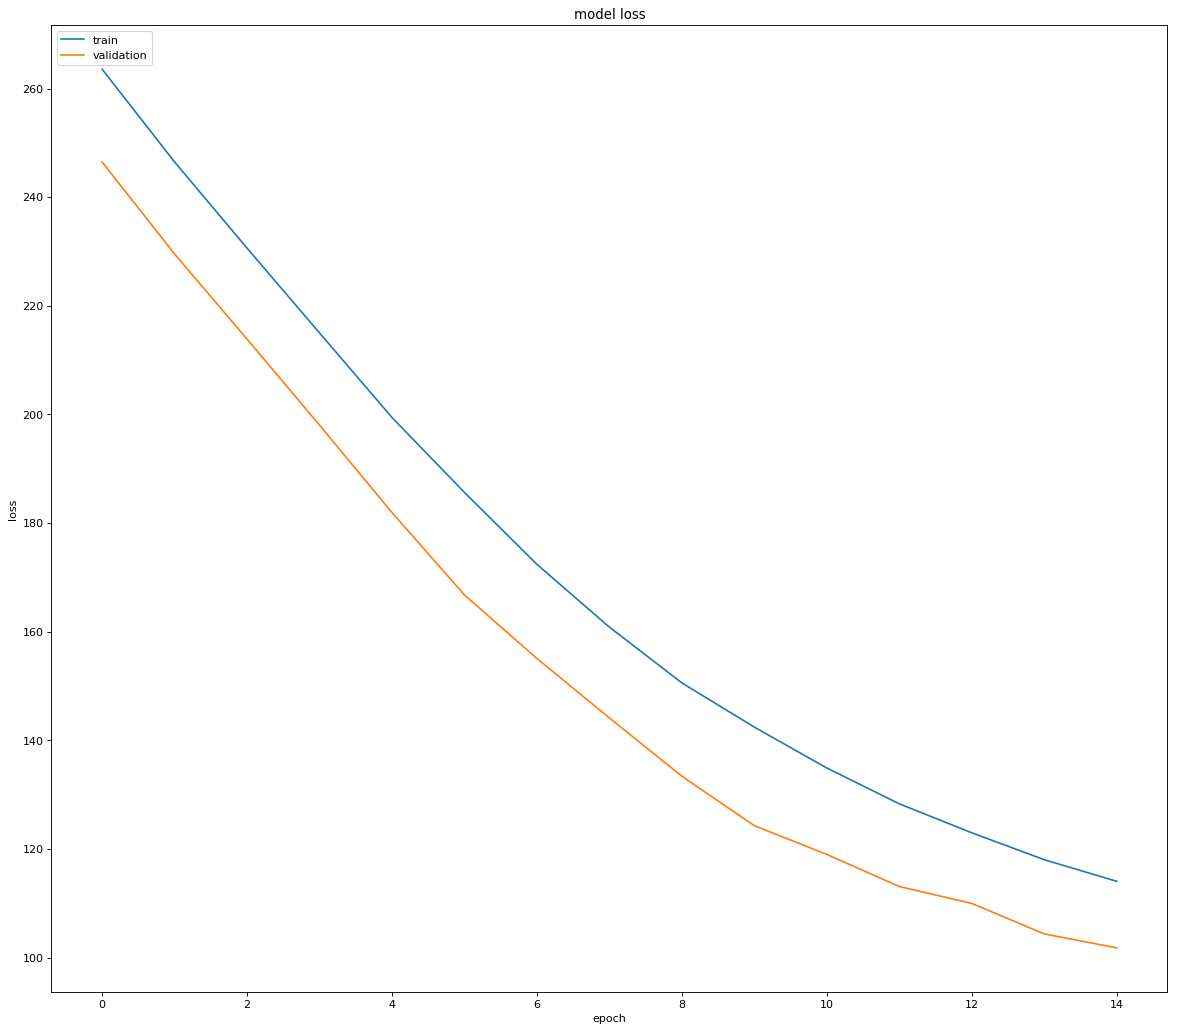

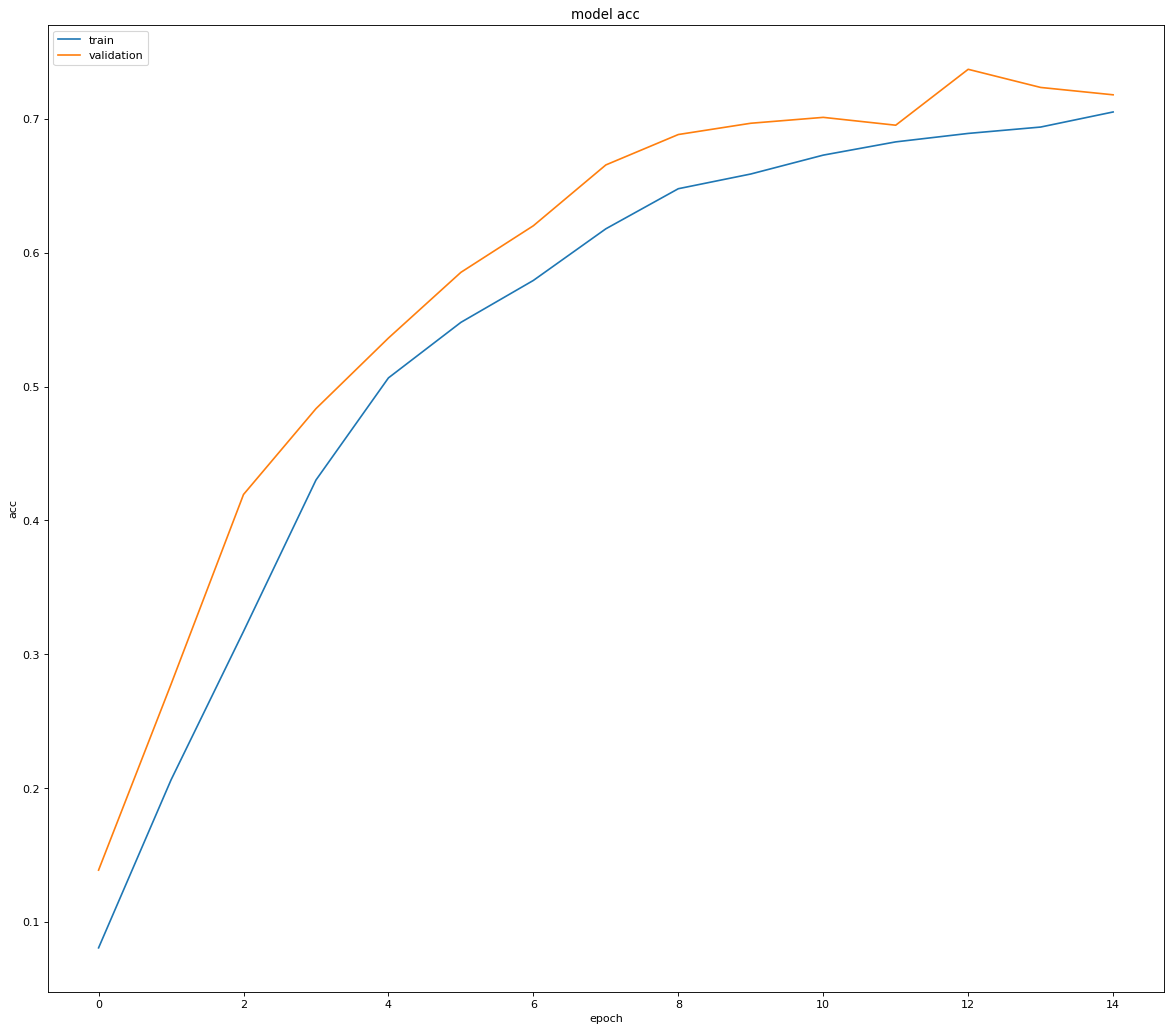

Balanced Accuracy:  0.6898480510009488
Normalized confusion matrix


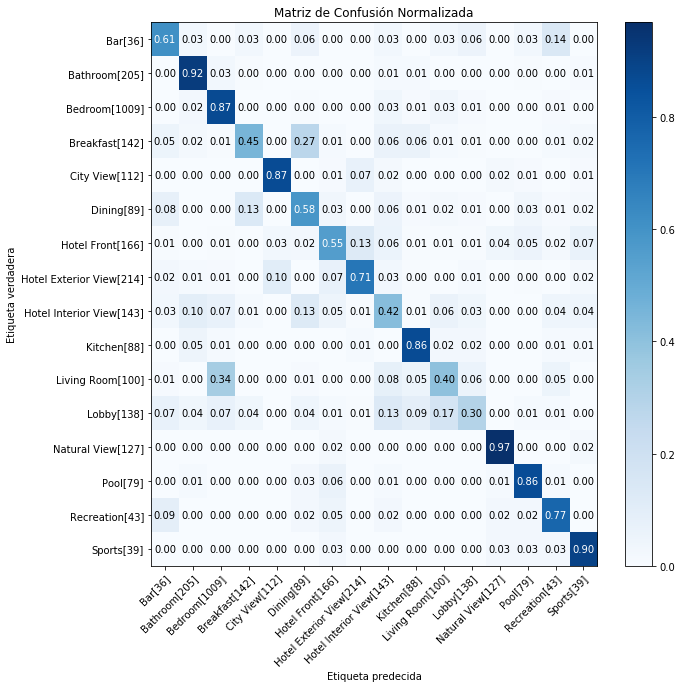

SGD_1e-05_LRSchedReduceLROnPlateau_20ep16bs
Use validation set:  True
Epoch 0/9
----------
Usando scheduler
Val loss: inf
Epoch     0: reducing learning rate of group 0 to 1.0000e-06.
loss: 201.6058 val_loss: 127.2252 acc: 0.4092 val_acc: 0.6751
Saved at epoch.
Epoch 1/9
----------
Usando scheduler
Val loss: 127.22520234942873
loss: 117.2064 val_loss: 91.1302 acc: 0.6863 val_acc: 0.7377
Saved at epoch.
Epoch 2/9
----------
Usando scheduler
Val loss: 91.13019742581434
loss: 92.8945 val_loss: 78.9918 acc: 0.7258 val_acc: 0.7571
Saved at epoch.
Epoch 3/9
----------
Usando scheduler
Val loss: 78.99179812420856
loss: 77.9727 val_loss: 73.2324 acc: 0.7559 val_acc: 0.7835
Saved at epoch.
Epoch 4/9
----------
Usando scheduler
Val loss: 73.23235841129289
loss: 67.2076 val_loss: 71.7600 acc: 0.7853 val_acc: 0.7861
Saved at epoch.
Epoch 5/9
----------
Usando scheduler
Val loss: 71.75999038193252
loss: 58.3542 val_loss: 68.9572 acc: 0.7988 val_acc: 0.8055
Saved at epoch.
Epoch 6/9
----------
Usand

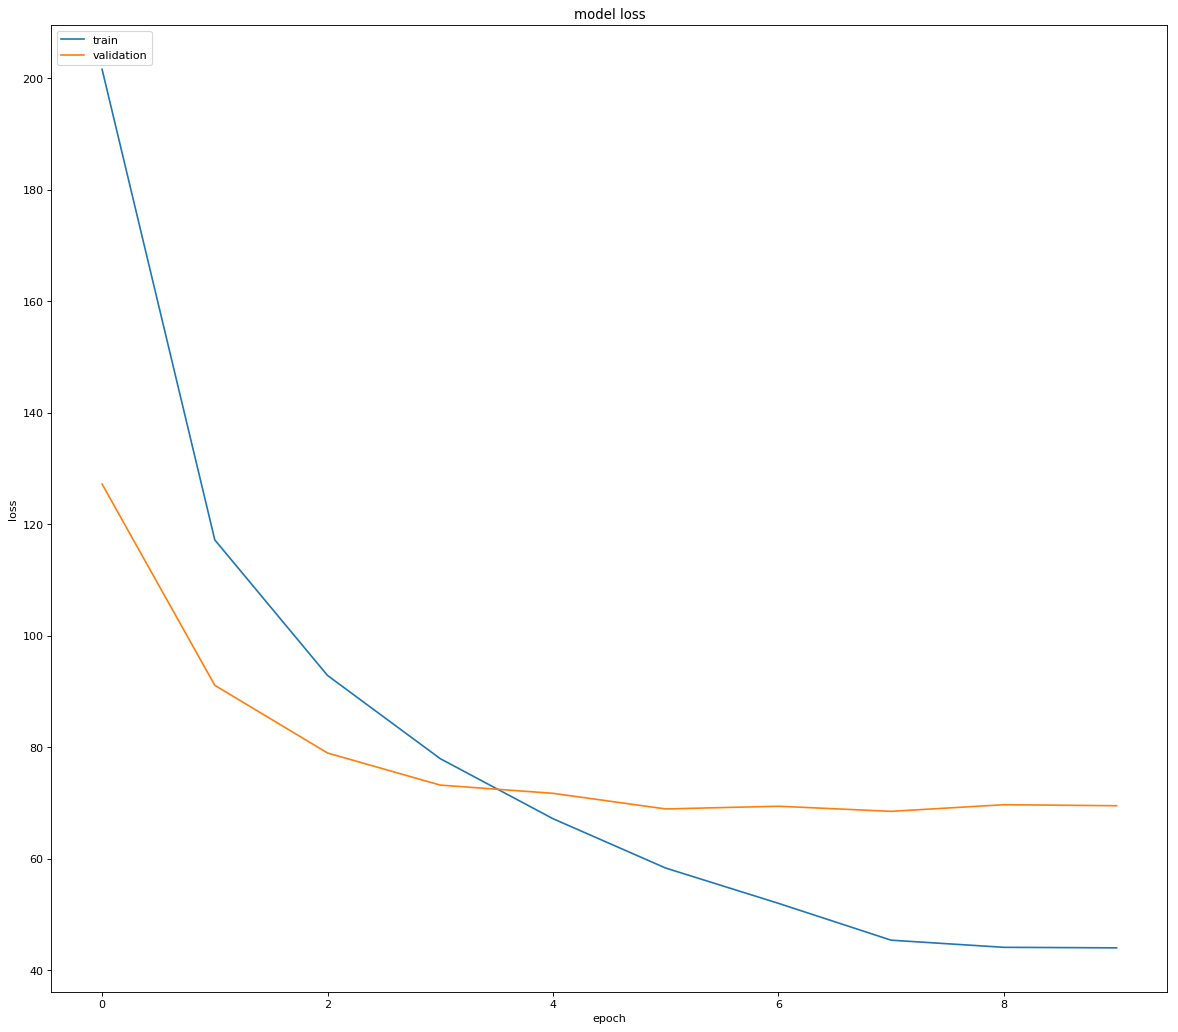

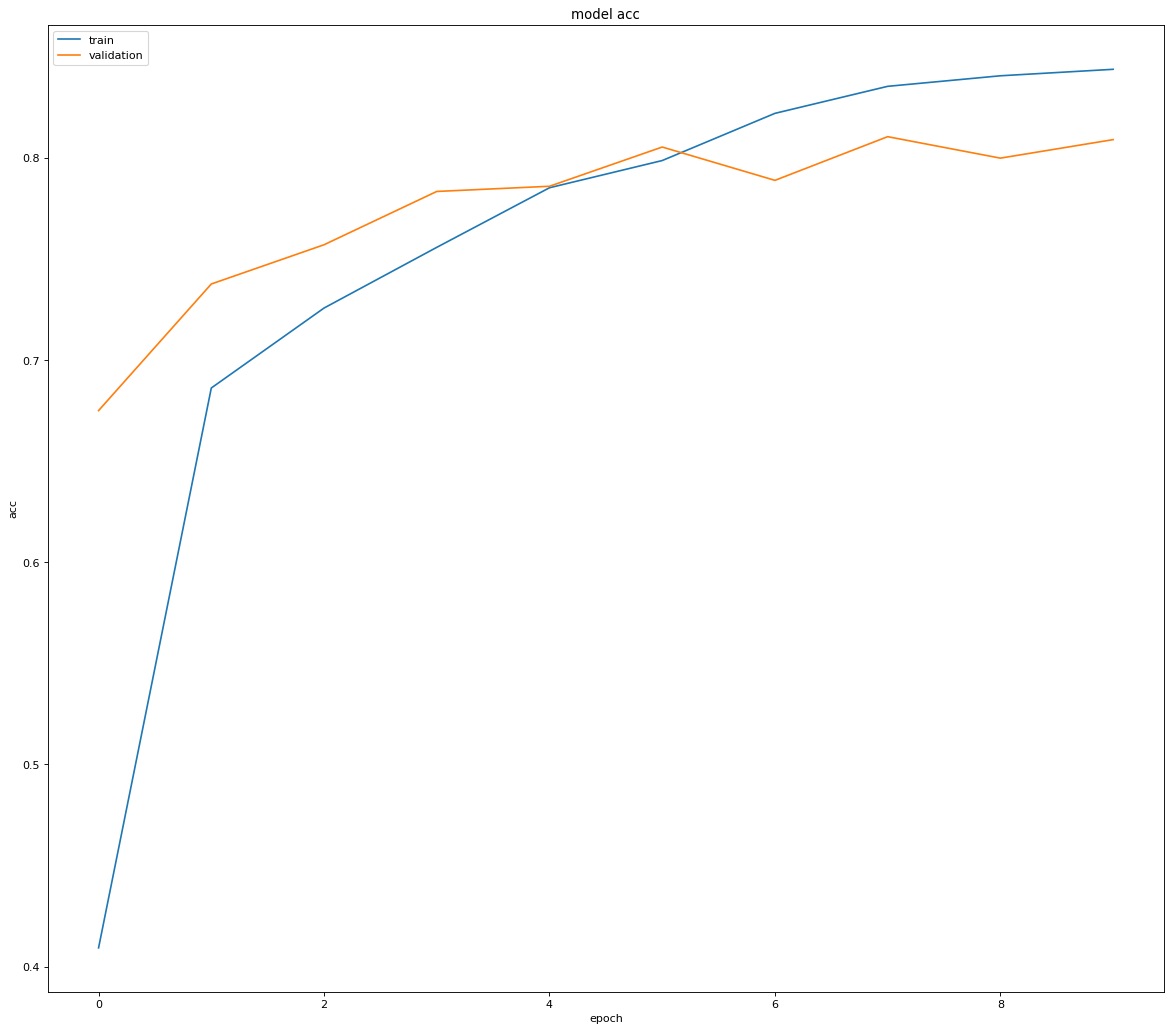

Balanced Accuracy:  0.7818208218693619
Normalized confusion matrix


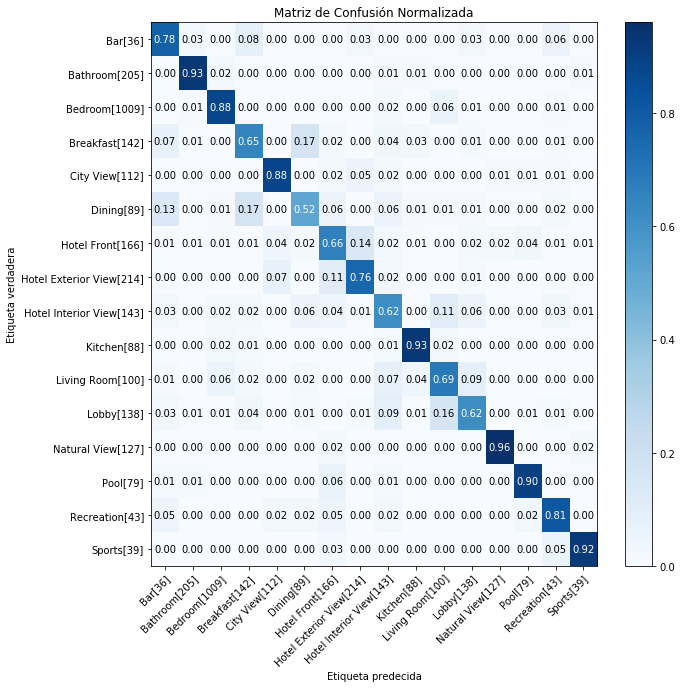

SGD_0.0001_LRSchedReduceLROnPlateau_20ep16bs
Use validation set:  True
Epoch 0/9
----------
Usando scheduler
Val loss: inf
Epoch     0: reducing learning rate of group 0 to 1.0000e-05.


RuntimeError: CUDA error: out of memory

In [16]:
model_name = 'resnet152' # model_name : alexnet, resnet, vgg19
learning_rate = 1e-5
optimizer_name = 'SGD' # optimizer_name: SGD, Adam, RMSProp
scheduler_step = 'ReduceLROnPlateau' # ReduceLROnPlateau, StepLR, CosineAnnealingLR

epochs = 20

def model_train_and_eval(model_name, learning_rate, optimizer_name, scheduler_step=None, epochs=10, weight_decay=0):
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, extra_info = create_model(model_name, learning_rate, scheduler_step, optimizer_name, weight_decay=weight_decay)
    model_ft, stats = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=epochs)
    save_model(model_name, model_ft, extra_info)
    plot_loss(model_name, stats, extra_info)
    plot_acc(model_name, stats, extra_info)
    y_true, y_pred = get_eval(model_ft,'valid')
    calculate_balanced_accuracy(y_true, y_pred)
    save_confusion_matrix(y_true, y_pred, model_name, extra_info)

# model_train_and_eval(model_name, learning_rate, optimizer_name, scheduler_step, epochs)    
#Best
#model_train_and_eval(model_name, 1e-4, 'SGD', 'ReduceLROnPlateau', 15,weight_decay= 1e-1)
#model_train_and_eval(model_name, 1e-4, 'SGD', 'ReduceLROnPlateau', 15,weight_decay= 1e-2)
#model_train_and_eval(model_name, 1e-4, 'SGD', 'ReduceLROnPlateau', 15,weight_decay= 0)
#model_train_and_eval(model_name, 1e-5, 'SGD', 'ReduceLROnPlateau', 10, weight_decay=1e-2)
model_train_and_eval(model_name, 1e-6, 'SGD', 'ReduceLROnPlateau', 15, weight_decay=2e-1)
model_train_and_eval(model_name, 1e-5, 'SGD', 'ReduceLROnPlateau', 10, weight_decay=1e-1)
model_train_and_eval('vgg19_bn', 1e-4, 'SGD', 'ReduceLROnPlateau', 10, weight_decay=1e-1)
model_train_and_eval('densenet', 1e-4, 'SGD', 'ReduceLROnPlateau', 10, weight_decay=1e-1)
